In [1]:
import StatsArbFunctions

import pandas as pd

from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data Fetching

In [2]:
start_date = datetime(2011, 1, 1)
end_date = datetime(2024, 3, 1)

data = StatsArbFunctions.DataFetcher(start_date=start_date, end_date=end_date)
price_data = data.get_data(column='Close')
volume_data = data.get_data(column='Volume')
train_data, test_data, volume_train_data, volume_test_data = data.split_data(price_data, volume_data)
train_tbill = train_data['^TNX'].mean() / 100
test_tbill = test_data['^TNX'].mean()/100
plotter = StatsArbFunctions.Plotter()

price_data.head(3)

Ticker,600028.SS,600519.SS,601318.SS,601766.SS,601939.SS,ABEV,ALSEA.MX,AMX,BBD,BOLSAA.MX,...,KOF,MELI,MTN.JO,NPN.JO,PAM,RELIANCE.NS,SBK.JO,TCS.NS,VALE3.SA,^TNX
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,6.307692,139.368896,28.455,8.29,4.66,5.244,12.682024,29.049999,12.866266,25.959999,...,82.290001,70.639999,13225.0,25106.388672,16.940001,492.413879,10932.0,572.375000,58.150002,3.346
2011-01-05,6.238461,136.048080,27.430,8.33,4.65,5.172,12.691764,29.440001,12.953919,26.100000,...,82.769997,72.110001,13090.0,24578.626953,17.049999,491.819580,10931.0,579.474976,59.200001,3.483
2011-01-06,6.215384,135.416977,26.295,8.25,4.58,5.096,12.701504,29.410000,12.421738,26.100000,...,83.010002,74.540001,12990.0,24170.240234,16.650000,496.299805,11000.0,585.849976,58.439999,3.419


## Cointegration

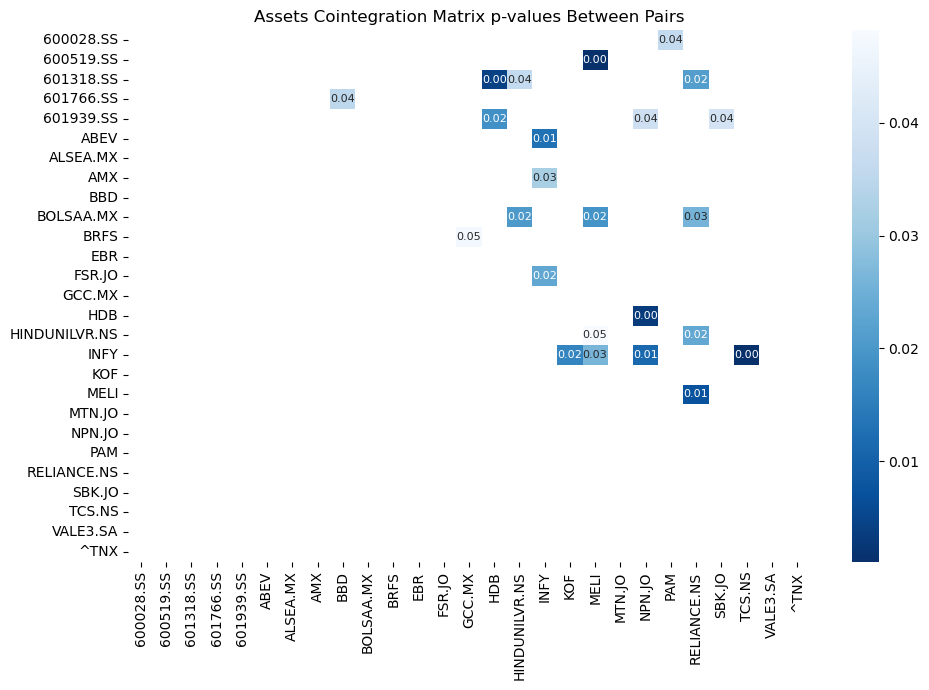

In [3]:
train_pvalues, train_pairs = StatsArbFunctions.CointegrationAnalysis.cointegration(train_data)

plotter.plot_cointegration_matrix(train_pvalues, train_data)

## Correlation

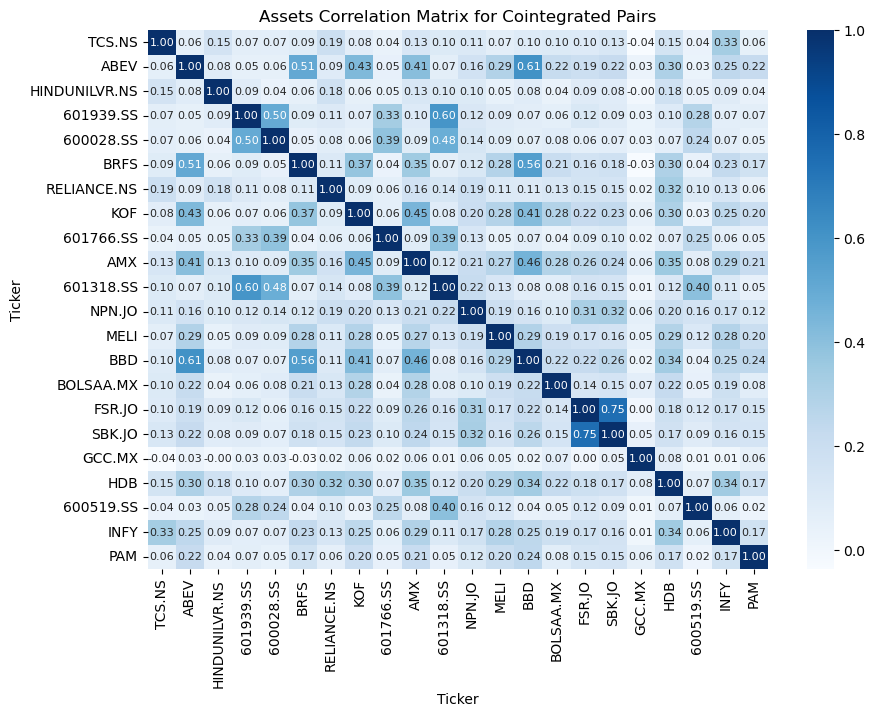

In [4]:
train_unique_assets = list(set([col for pair in train_pairs for col in pair]))
train_cointegrated_data = train_data[train_unique_assets].pct_change()
correlation_matrix = train_cointegrated_data.corr(method='pearson')

plotter.plot_correlation_matrix(correlation_matrix)

## Training

In [5]:
processor = StatsArbFunctions.PairProcessor()
processor.set_data(train_data, volume_data, train_pvalues, train_pairs, train_tbill)
sorted_train_unique_results = processor.process_all_pairs()
filtered_portfolio_data, top_pair, best_pair_data = processor.get_top_sharpe_pairs(top_n=5)

Top Sharpe Ratios:
                Pair  Sharpe Ratio
20      (INFY, MELI)      2.894556
19       (INFY, KOF)      1.793661
6   (601939.SS, HDB)      1.693220
5   (601766.SS, BBD)      1.508943
0   (600028.SS, PAM)      1.458707


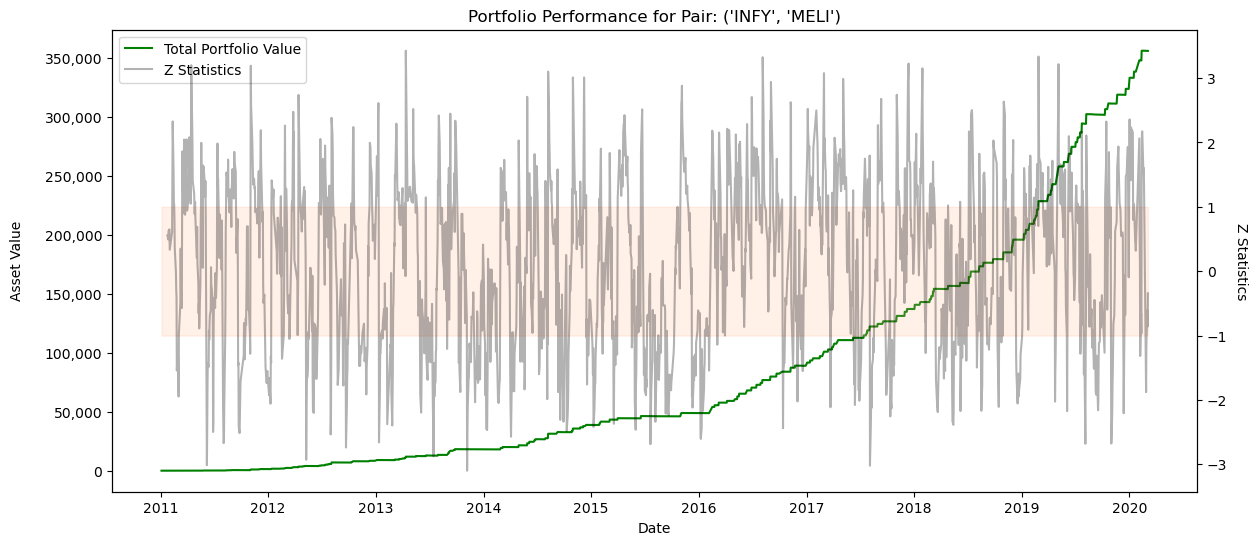

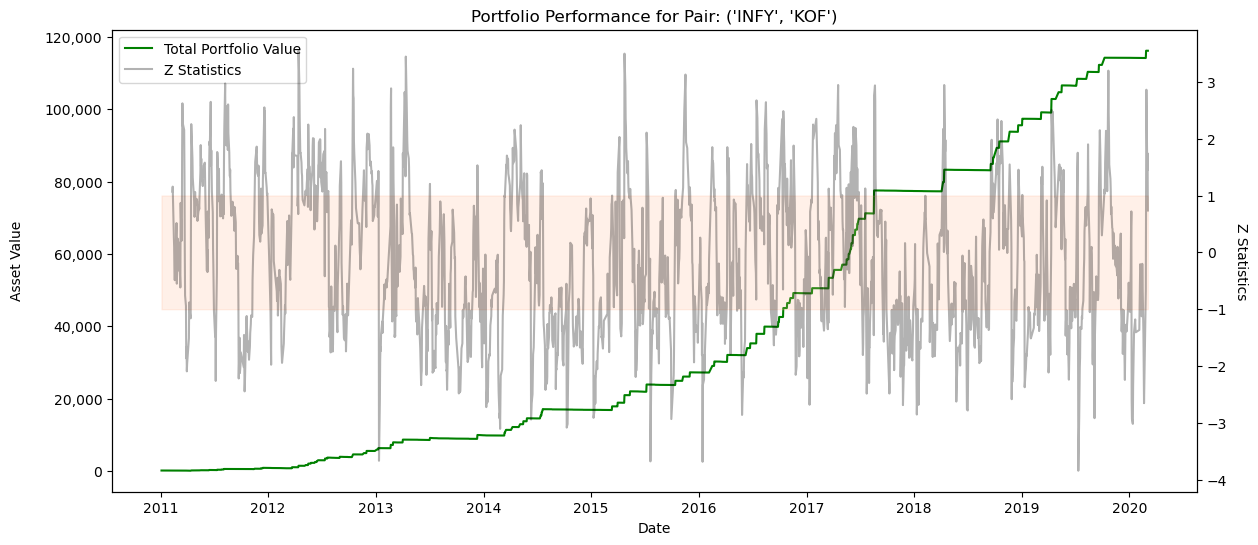

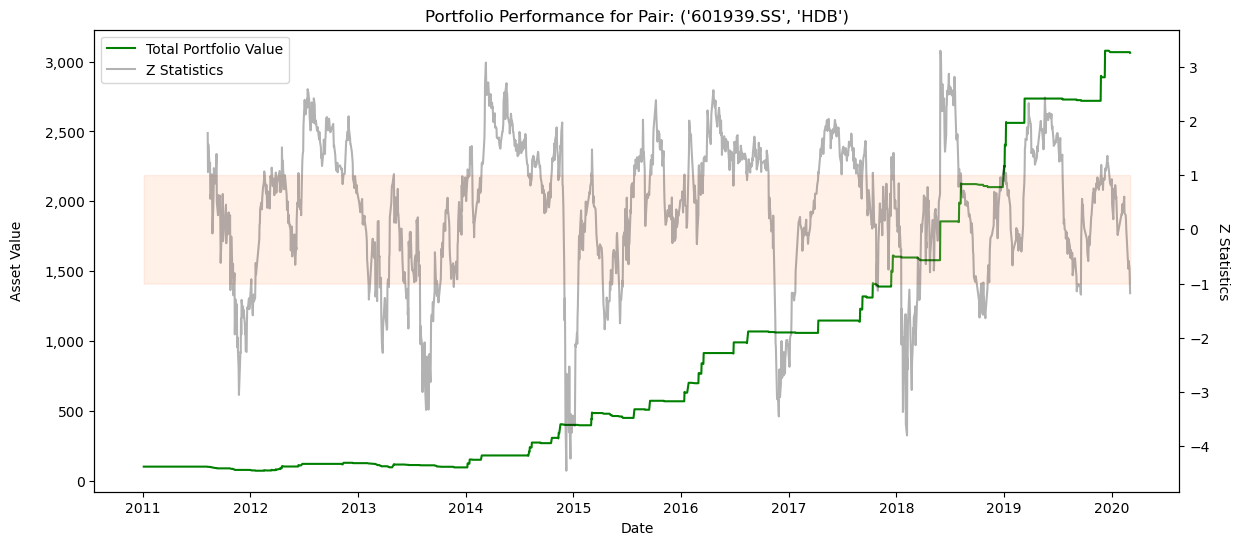

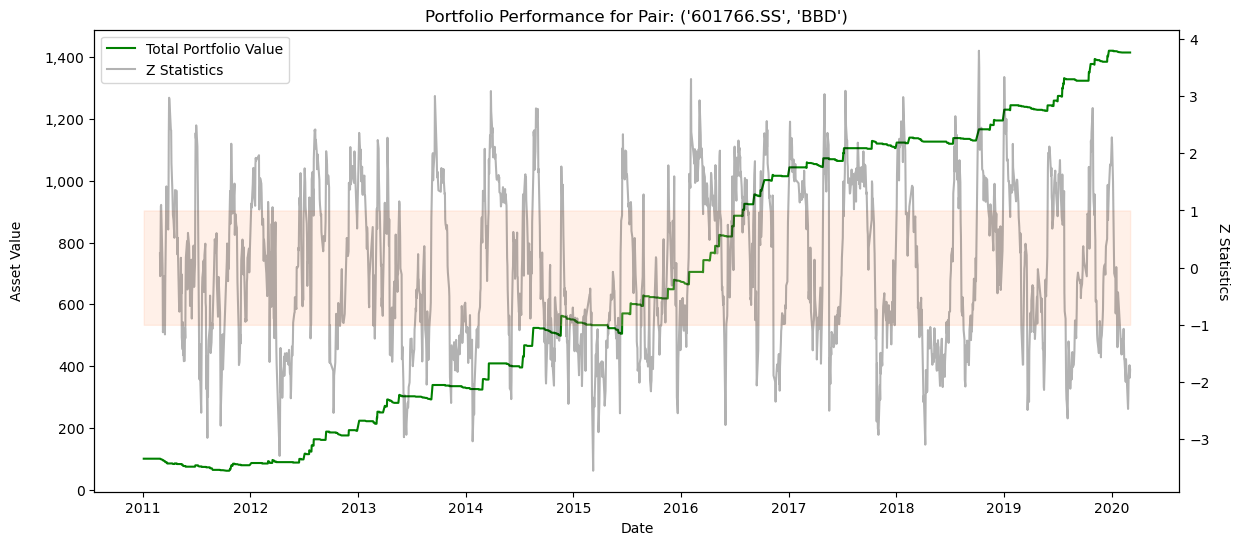

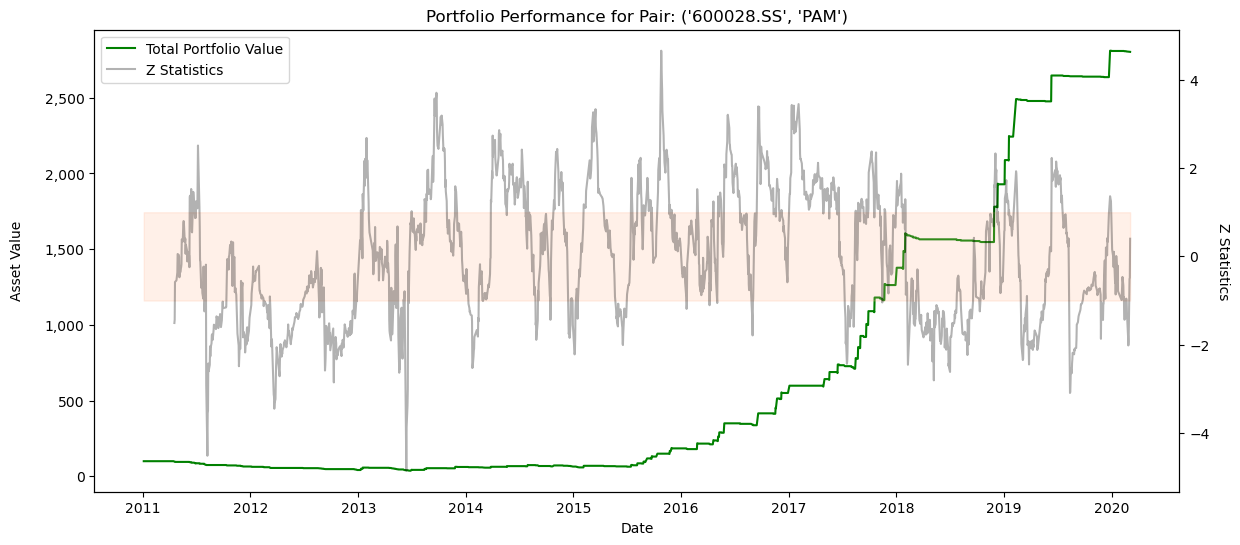

In [6]:
plotter.plot_pairs_trading_performance(filtered_portfolio_data, train_data.index)

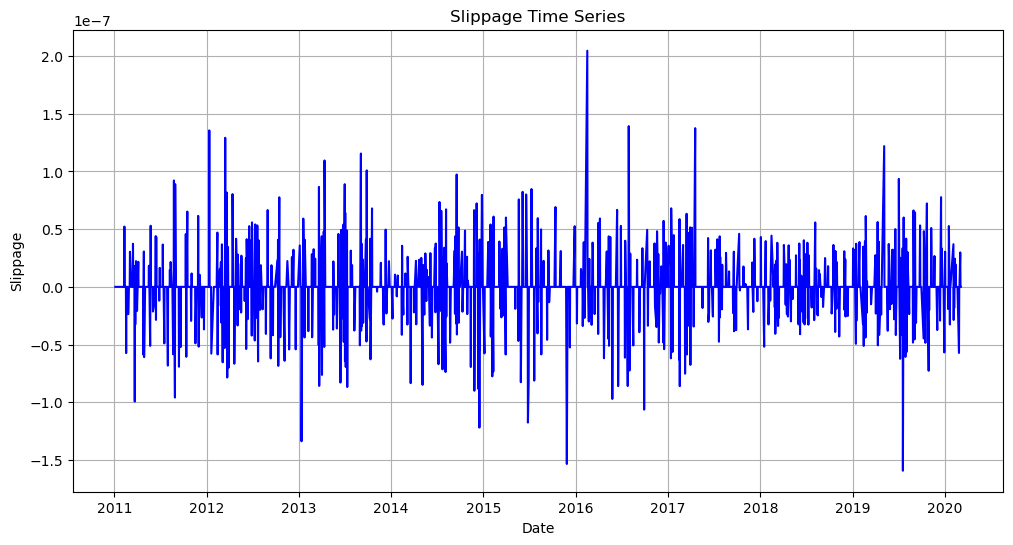

In [7]:
train_slippage_series = best_pair_data['slippage']
train_time_index = train_data.iloc[1:].index

plotter.plot_slippage_time_series(train_time_index, train_slippage_series)

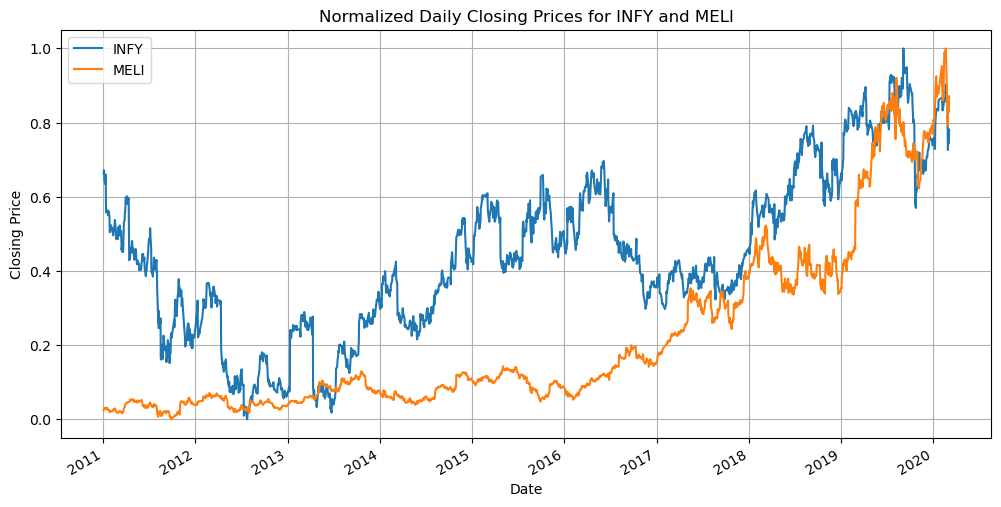

In [8]:
plotter.plot_normalized_prices(train_data, top_pair)

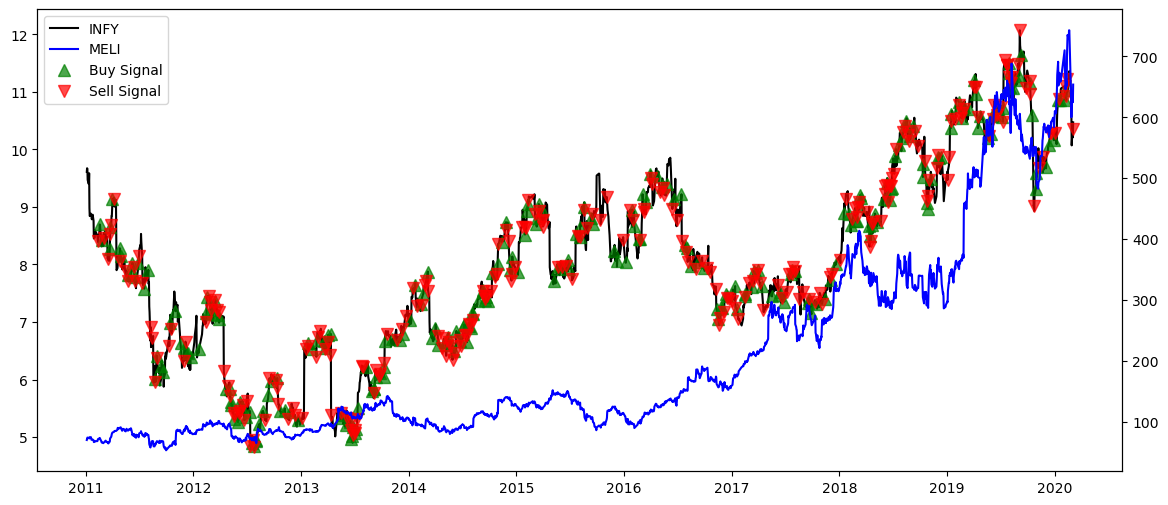

In [9]:
plotter.plot_signals(train_data, filtered_portfolio_data, top_pair)

In [10]:
train_results = StatsArbFunctions.TradingMetrics.calculate_trading_metrics(filtered_portfolio_data, date_index=train_data.index)

for pair, data in train_results.items():
    print(f"Metrics for {pair}:\n")
    print(data['table'])
    print("\n\n")

Metrics for ('INFY', 'MELI'):

+--------------------------+-------------+
|          Metric          |    Value    |
+--------------------------+-------------+
|           CAGR           |    75.691   |
|     Terminal Wealth      |  356230.57  |
|     Number of Trades     |     1042    |
| Number of Winning Trades |     139     |
| Number of Losing Trades  |     308     |
|        Win Ratio         |   13.3397   |
|       Gross Profit       | 333845.0288 |
|        Gross Loss        |  8362.5055  |
|      Profit Factor       |    39.92    |
|       Average Gain       |   2401.76   |
|       Average Loss       |    27.15    |
+--------------------------+-------------+



Metrics for ('INFY', 'KOF'):

+--------------------------+-------------+
|          Metric          |    Value    |
+--------------------------+-------------+
|           CAGR           |    61.481   |
|     Terminal Wealth      |  116211.07  |
|     Number of Trades     |     897     |
| Number of Winning Trades |     

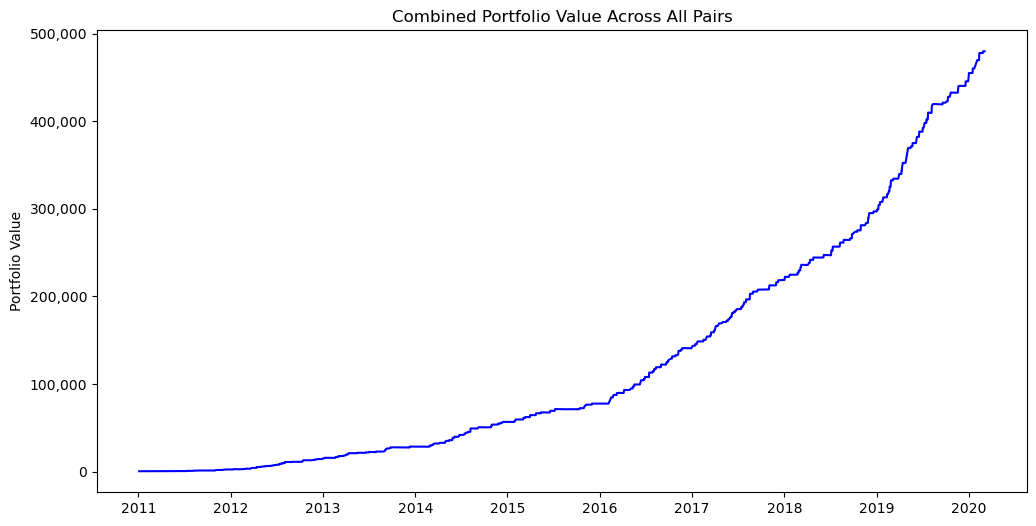

In [11]:
train_combined_portfolio = pd.DataFrame(index=train_data.index)
train_combined_portfolio['total asset'] = sum(
    [pd.Series(portfolio['total_asset'], index=train_data.index) for portfolio in filtered_portfolio_data.values()]
)

plotter.plot_combined_portfolio(filtered_portfolio_data, train_data.index)

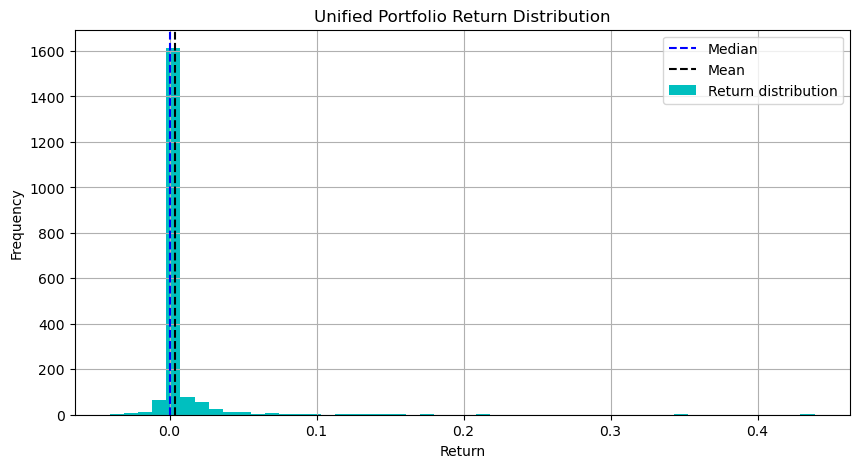

In [12]:
plotter.plot_return_distribution(train_combined_portfolio)

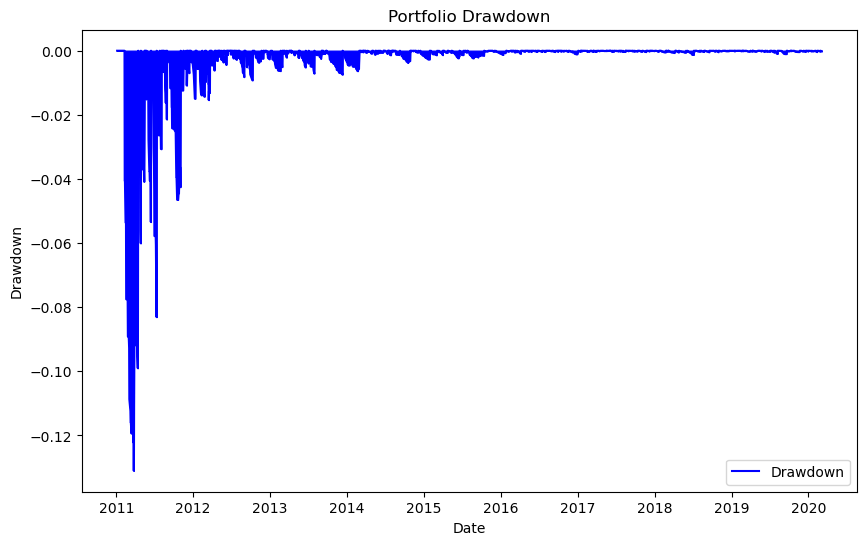

In [13]:
plotter.plot_drawdown(train_combined_portfolio)

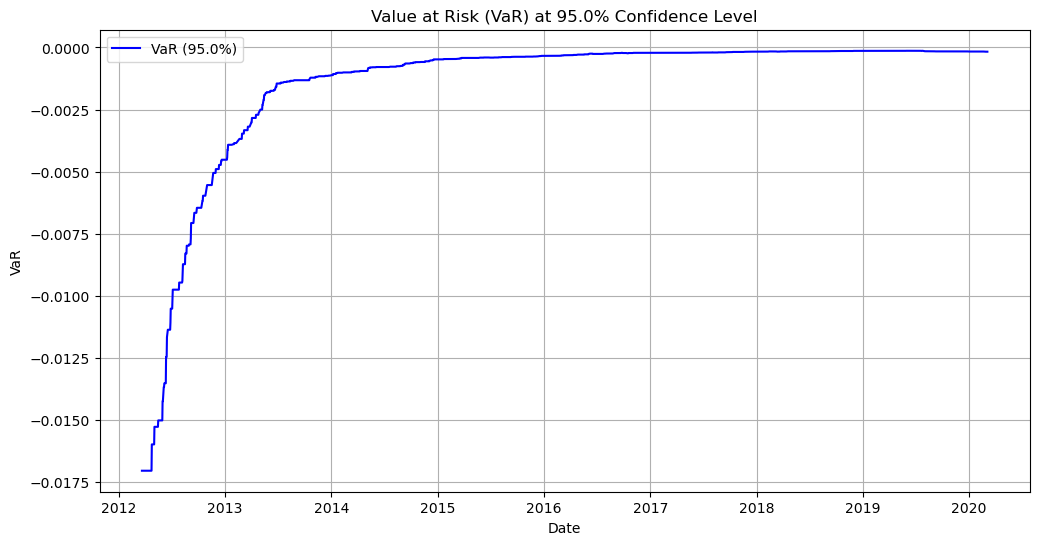

In [14]:
plotter.plot_var(train_combined_portfolio, confidence_level=0.95)

In [15]:
StatsArbFunctions.FinancialMetrics.summary_stats(pd.DataFrame(train_combined_portfolio['returns']), riskfree_rate=train_tbill)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Tail Ratio
returns,0.0439,0.0703,0.0134,10.605,173.7602,NaN,-0.1444,NaN,0,0.2924,2.1171,0.157,1.4235,-0.131,7316.7358,NaN


## Test

In [16]:
initial_betas = {}
test_results = []

asset1, asset2 = top_pair
initial_betas[top_pair] = processor.portfolio_data[(asset1, asset2)]['hedge_ratios']
test_pair_results = processor.test_pair(asset1, asset2, test_data, initial_beta=initial_betas[top_pair])
test_results.extend(test_pair_results)
test_results_df = pd.DataFrame(test_results, columns=['Asset1', 'Asset2', 'Start', 'End', 'Beta (Kalman)', 'Half-life'])

simulator = StatsArbFunctions.PairsTradingSimulator()
test_results, test_portfolio_data = simulator.simulate_pairs_trading(
    data=test_data, liquidity_data=volume_test_data, cointegration_results=test_results_df
    )
sharpe_values_df = processor.calculate_sharpe_ratios()
top_sharpe_values = sharpe_values_df.sort_values(by='Sharpe Ratio', ascending=False).head(1)
top_pair = top_sharpe_values.iloc[0]['Pair']
top_sharpe_ratio = top_sharpe_values.iloc[0]['Sharpe Ratio']

print("Top Sharpe Ratio Pair from Test Data:", top_pair)
print("Top Sharpe Ratio Value:", round(top_sharpe_ratio, 2))

Top Sharpe Ratio Pair from Test Data: ('INFY', 'MELI')
Top Sharpe Ratio Value: 2.89


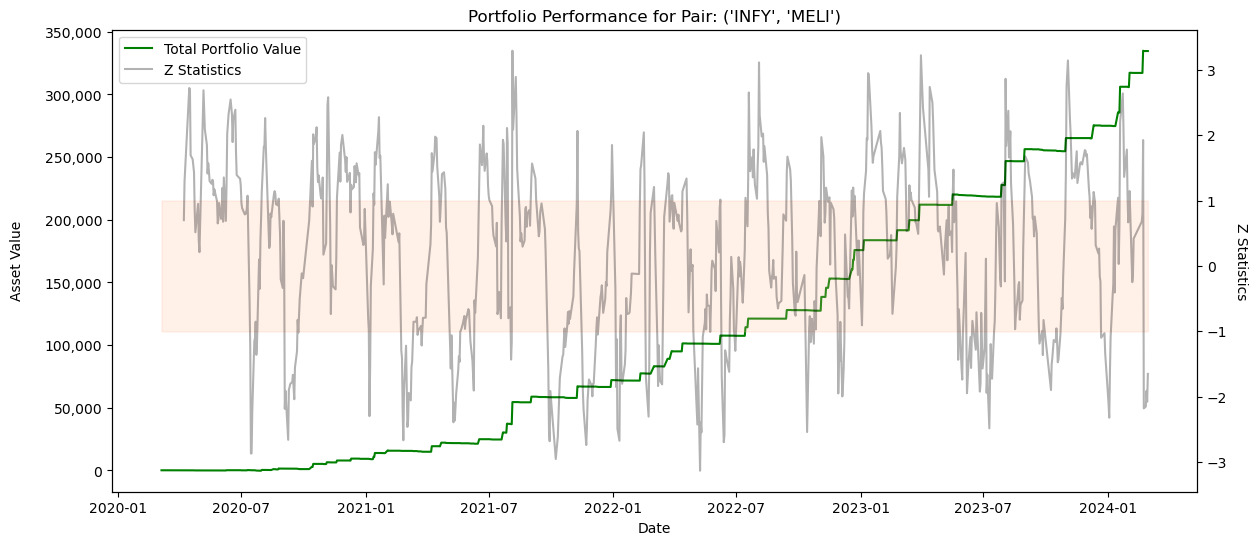

In [17]:
test_filtered_portfolio_data = {top_pair: test_portfolio_data[top_pair]}

plotter.plot_pairs_trading_performance(test_filtered_portfolio_data, test_data.index)

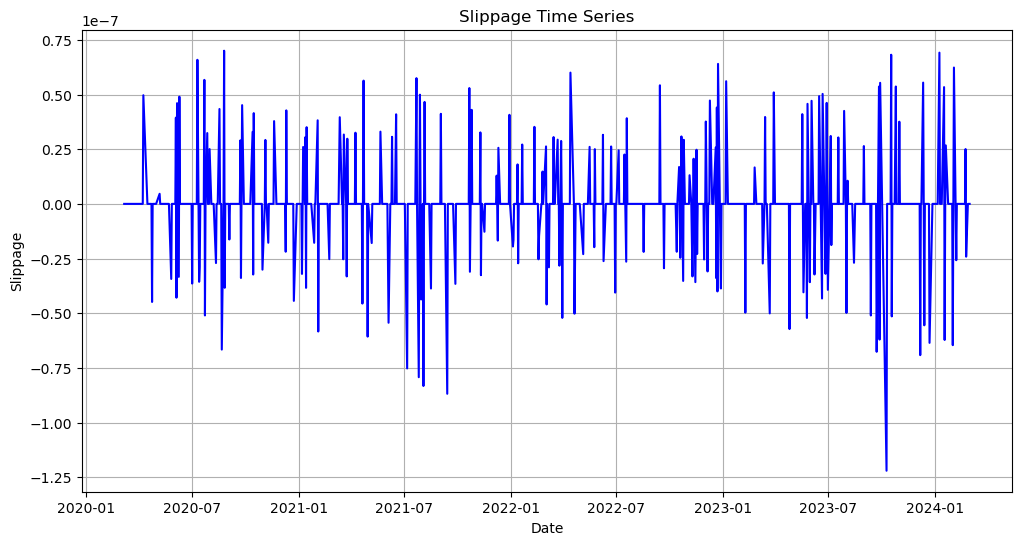

In [18]:
test_slippage_series = test_filtered_portfolio_data[top_pair]['slippage']
test_time_index = test_data.iloc[1:].index

plotter.plot_slippage_time_series(test_time_index, test_slippage_series)

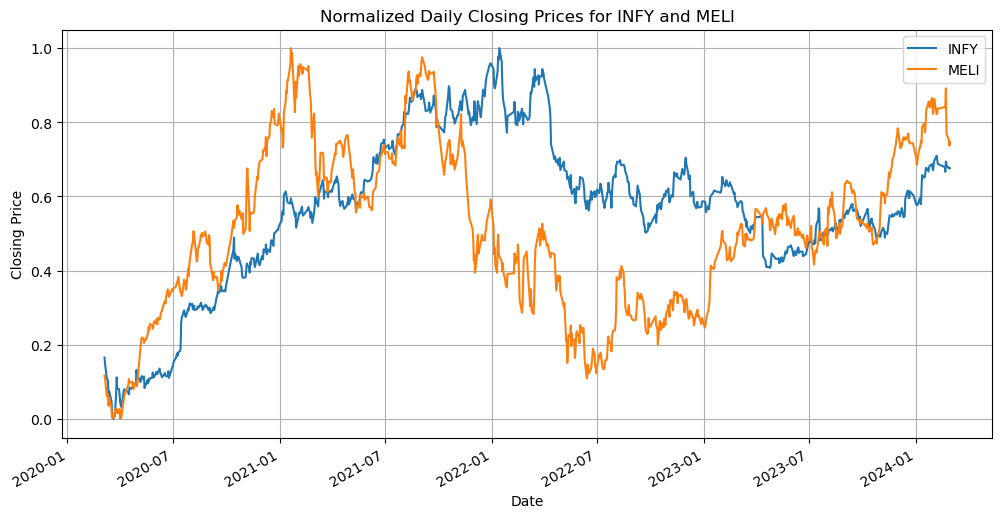

In [19]:
plotter.plot_normalized_prices(test_data, top_pair)

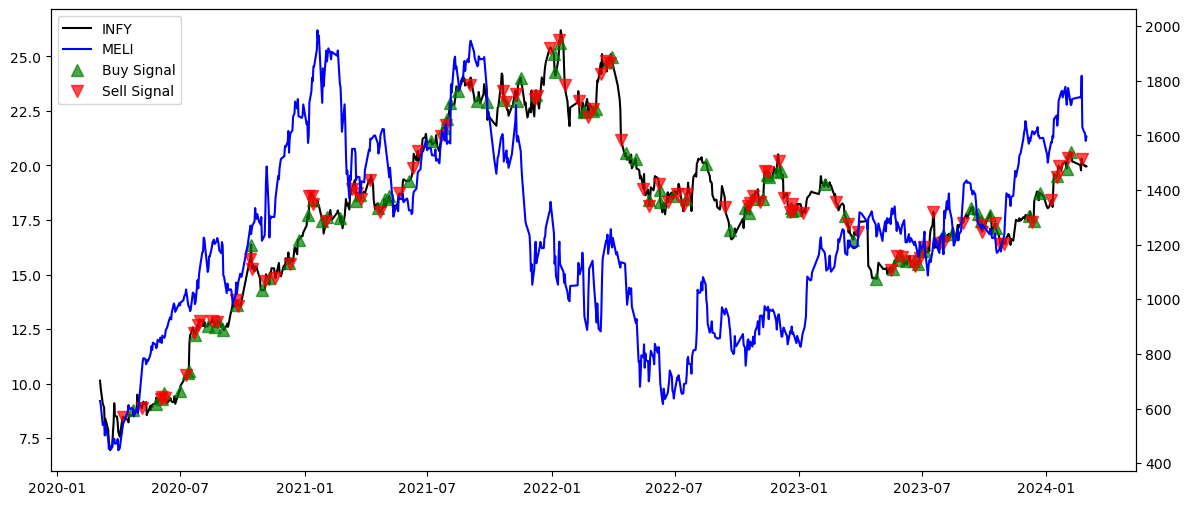

In [20]:
plotter.plot_signals(test_data, test_filtered_portfolio_data, top_pair)

In [21]:
test_results = StatsArbFunctions.TradingMetrics.calculate_trading_metrics(test_filtered_portfolio_data, date_index=test_data.index)

for pair, data in test_results.items():
    print(f"Metrics for {pair}:\n")
    print(data['table'])
    print("\n\n")

Metrics for ('INFY', 'MELI'):

+--------------------------+-------------+
|          Metric          |    Value    |
+--------------------------+-------------+
|           CAGR           |   261.3468  |
|     Terminal Wealth      |  334650.78  |
|     Number of Trades     |     374     |
| Number of Winning Trades |      52     |
| Number of Losing Trades  |     107     |
|        Win Ratio         |   13.9037   |
|       Gross Profit       | 351930.4048 |
|        Gross Loss        |  17092.467  |
|      Profit Factor       |    20.59    |
|       Average Gain       |   6767.89   |
|       Average Loss       |    159.74   |
+--------------------------+-------------+





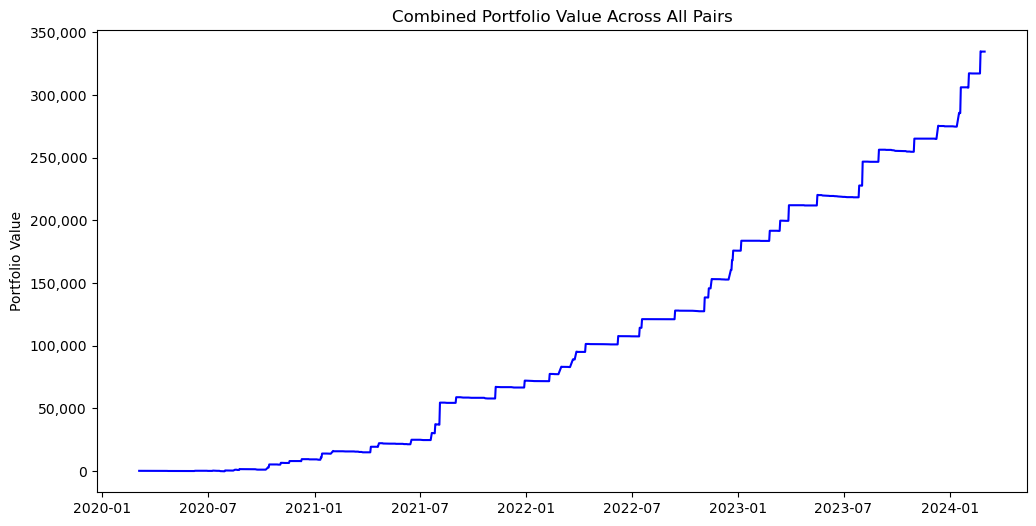

In [22]:
test_combined_portfolio = pd.DataFrame(index=test_data.index)
test_combined_portfolio['total asset'] = sum(
    [pd.Series(portfolio['total_asset'], index=test_data.index) for portfolio in test_filtered_portfolio_data.values()]
)

plotter.plot_combined_portfolio(test_filtered_portfolio_data, test_data.index)

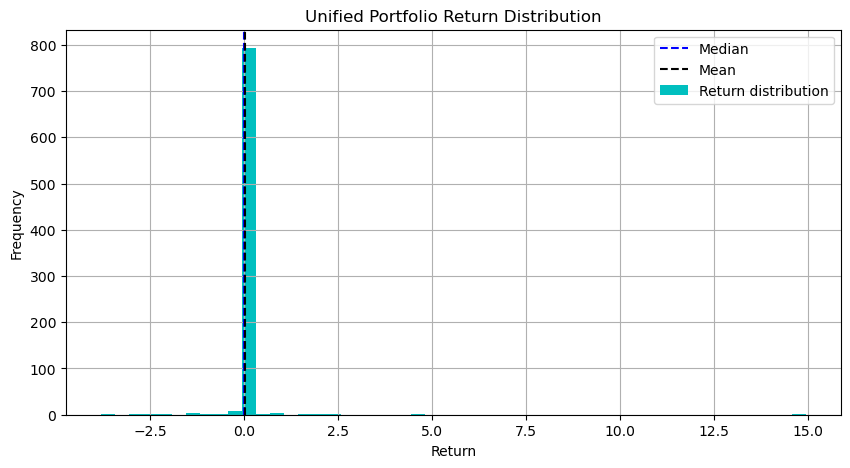

In [23]:
plotter.plot_return_distribution(test_combined_portfolio)

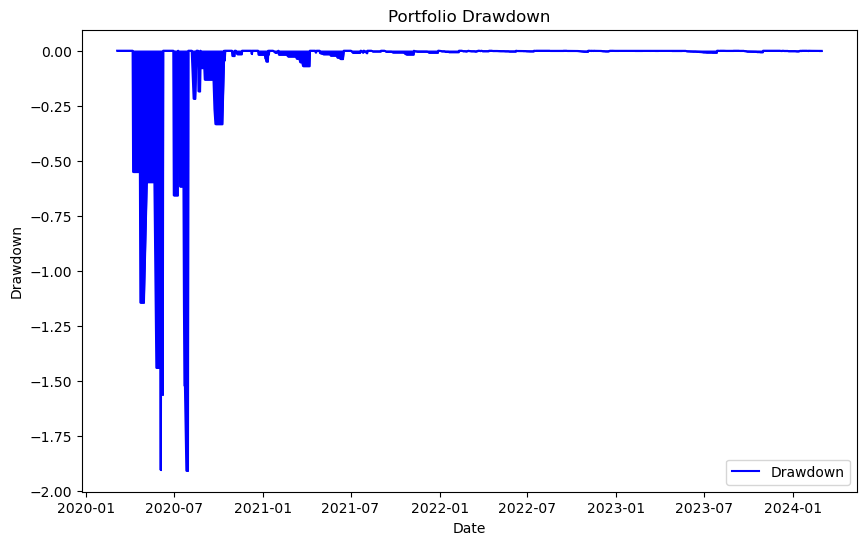

In [24]:
plotter.plot_drawdown(test_combined_portfolio)

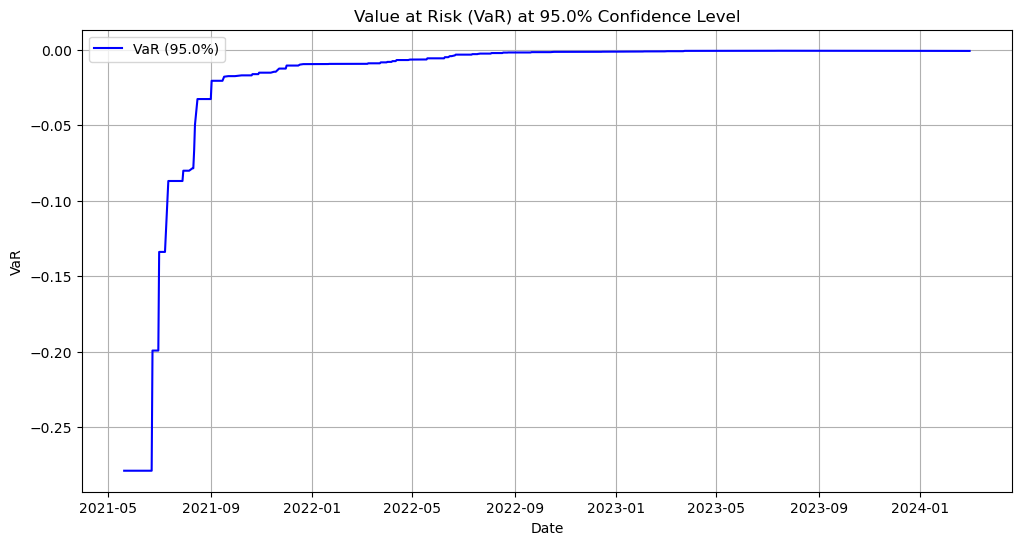

In [25]:
plotter.plot_var(test_combined_portfolio, confidence_level=0.95)

In [26]:
StatsArbFunctions.FinancialMetrics.summary_stats(pd.DataFrame(test_combined_portfolio['returns']), riskfree_rate=test_tbill)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Tail Ratio
returns,0.1258,2.1399,2.1084,16.9572,424.1727,NaN,-10.5541,NaN,0,0.0467,0.1092,0.0524,0.3704,-1.907,1754.3637,NaN
